In [ ]:
from pathlib import Path
import warnings
import os
warnings.filterwarnings("ignore")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe
import cartopy.crs as ccrs

from deepS2S.preprocessing.climatology import climatology_and_anomalies
from deepS2S.utils.utils_plot import plot_examples


In [ ]:
# set variable downloaded from the 20th century Reanalysis Data
vrbl = 'olr'
cfd = Path(os.getcwd()).parent.absolute()
data_dir = str(Path(cfd).parent.absolute()) + '/Data/'
par_cdf = cfd.parent.absolute()

ddir = str(Path(cfd).parent.absolute()) + '/Data/'
data_name = '20CRv3'
results_directory = f'{ddir}/Data/{data_name}/Preprocessing'


In [ ]:
# User Configuration : Change these values to generate different datasets
if vrbl == 'pressure':
    var_name = 'z' # available: 't2m', 'tp', 'z'
    pressure_level = 500 # in hPa, ignored for variables without levels. available: 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1,000
    region = 'northern_hemi' # available: 'global', 'europe', 'northern_hemi'
elif vrbl == 'olr': 
    var_name = 'olr' # available: 't2m', 'tp', 'z'
    region = 'mjo' # available: 'global', 'europe', 'northern_hemi'
    pressure_level = 500 # in hPa, ignored for variables without levels. available: 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1,000
elif vrbl == 'pv':
    var_name = 'u' 
    pressure_level = 10 # in hPa, ignored for variables without levels. available: 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1,000
    region = 'spv' # available: 'global', 'europe', 'northern_hemi'
yr30 = True #calculate 30 yr batch-wise climatology (WMO 2020) 
resolution = '1.40625' # in degrees, available: '5.625'
start_year, end_year = 1836, 1980 # set both to None to use all available years
reduce_to_single_dim = False # if True, the dataset will be reduced to a single dimension (time) by aggregating over the other dimensions
months_to_keep = [11, 12, 1, 2, 3]
start_season, end_season = '11-15', '03-31'

VISUALIZE = True # if True, the dataset will be visualized

In [ ]:
# Configuration : Do not change these values
region_coords = {
    'europe': {'lat': slice(30, 50), 'lon': slice(-10, 20)},
    'northern_hemi': {'lat': slice(-10, 90)},
    'southern_hemi': {'lat': slice(-90, 10)},
    'spv': {'lat': slice(59,90)}, # z50 for Polar Vortex
    'mjo': {'lat': slice(-15,15)}, # t2m for MJO
    'global': None
}[region]
aggregate_func = {'u': 'mean', 'z': 'mean', 'olr': 'mean'}[var_name]
var_name_map = { 'z': 'hgt', 'u': 'uwnd','olr':'ulwrf'}
var_full = {'z': 'z', 'u': 'u','olr':'ulwrf'}
pressure_level = { 'u': pressure_level, 'z': pressure_level,'olr':''}[var_name]

In [ ]:
# Load the data
full_data_path = Path(f'{ddir}/{data_name}/raw/{var_name_map[var_name]}/{var_full[var_name]}_{pressure_level}_full.nc')
if not full_data_path.exists():
    ds = xr.open_mfdataset(f'{ddir}/{data_name}/raw/{var_name_map[var_name]}/{var_name_map[var_name]}*.nc', combine='by_coords', engine ="netcdf4")
   
    # change longitude from 0-360 to -180-180 for extraction of europe
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds = ds.roll(lon=int(len(ds['lon']) / 2), roll_coords=True)
  
    # Select pressure level
    if 'level' in ds.dims:
        ds = ds.sel(level=pressure_level)
    else:
        pressure_level = ''
    
    try:
        ds = ds.drop('time_bnds')
    except ValueError:
        pass
    if vrbl == 't2m': 
        ds.air.encoding = {}
    elif vrbl == 'pv':
        ds.uwnd.encoding = {}
    elif vrbl == 'olr':
        ds.ulwrf.encoding = {}
    else:
        ds.hgt.encoding = {}
       
    ds.to_netcdf(full_data_path, engine ="netcdf4")
else:
    ds = xr.open_dataset(full_data_path)


examples = np.random.choice(np.arange(len(ds.time)), 12)

In [ ]:
# regridding
grid_path = Path(f'{ddir}/{data_name}/raw/{resolution}deg_grid.nc')
if grid_path.exists():
    grid = xr.load_dataset(grid_path)
    regridder = xe.Regridder(ds, grid, "bilinear")
    ds = regridder(ds[var_name_map[var_name]])
else:
    print('No grid found. Skipping regridding.')

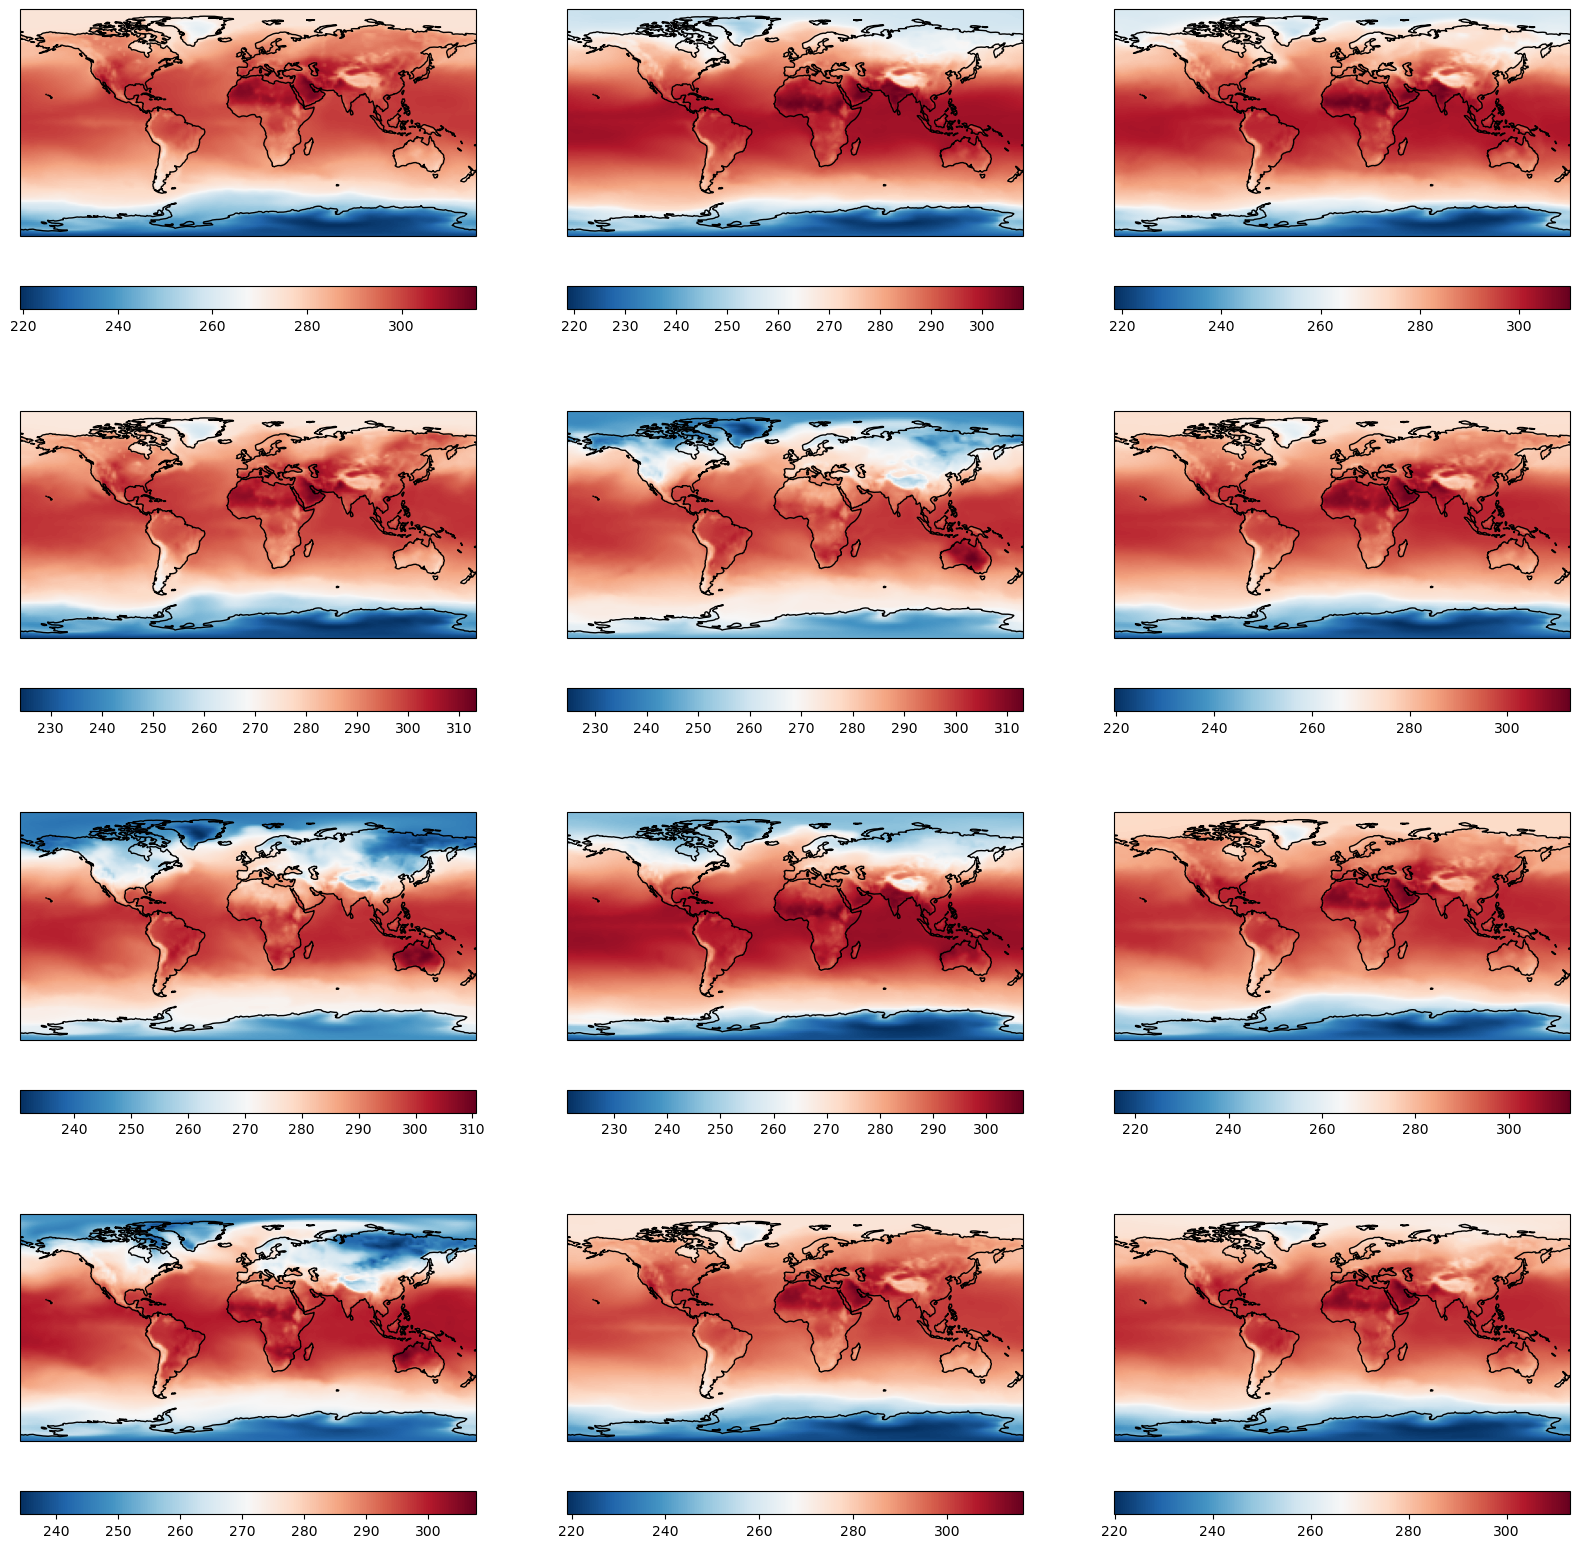

In [14]:
if VISUALIZE: 
    plot_examples(ds, examples=examples)

In [8]:
# Select years of interest
if start_year is not None:
    ds = ds.sel(time=slice(np.datetime64(f'{start_year}-01-01'), np.datetime64(f'{end_year}-12-31')))

# for naming purposes
if start_year is None:
    start_year = ds['time.year'].min().values
if end_year is None:
    end_year = ds['time.year'].max().values

In [9]:
# Select the region of interest
if region_coords:
    ds = ds.sel(**region_coords)

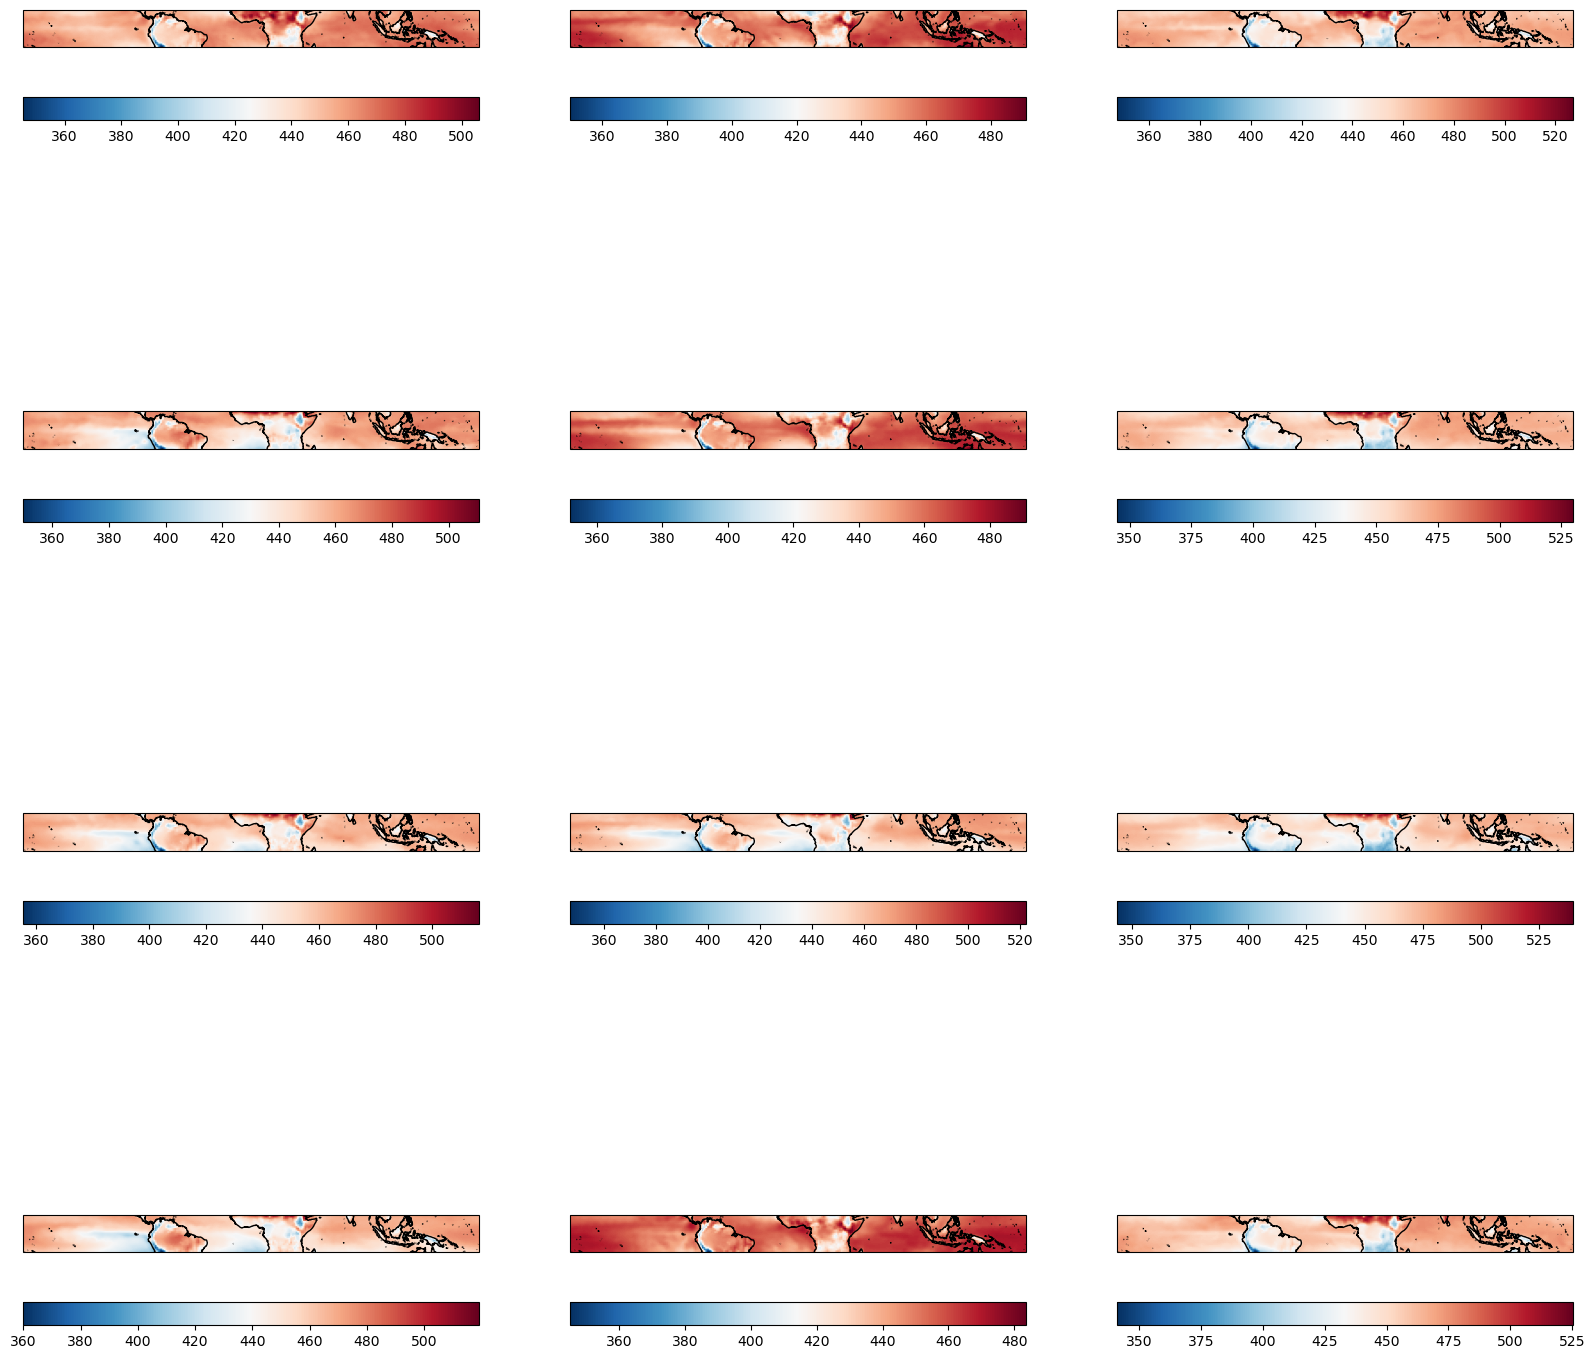

In [10]:
if VISUALIZE:
    examples = np.random.choice(np.arange(len(ds.time)), 12)
    plot_examples(ds, examples=examples)

In [ ]:
# Compute climatology

climatology_folder = Path(f'{ddir}/{data_name}/climatology')
climatology_folder.mkdir(exist_ok=True)

climatology_path = climatology_folder / Path(f'{var_name}_{resolution}deg_{pressure_level}_climatology.nc') 
if not climatology_path.exists():
    ds.groupby('time.dayofyear').mean('time').to_netcdf(climatology_path, engine ="netcdf4")

# Select the region and subtract climatology
yr30 = True
if yr30:
    ds = climatology_and_anomalies(ds, 30, f'{ddir}/{data_name}/climatology/{var_name}_{resolution}deg_{pressure_level}_climatology_')
else:
    climatology = xr.open_dataset(climatology_path).__xarray_dataarray_variable__

    ds = ds.groupby('time.dayofyear') - climatology

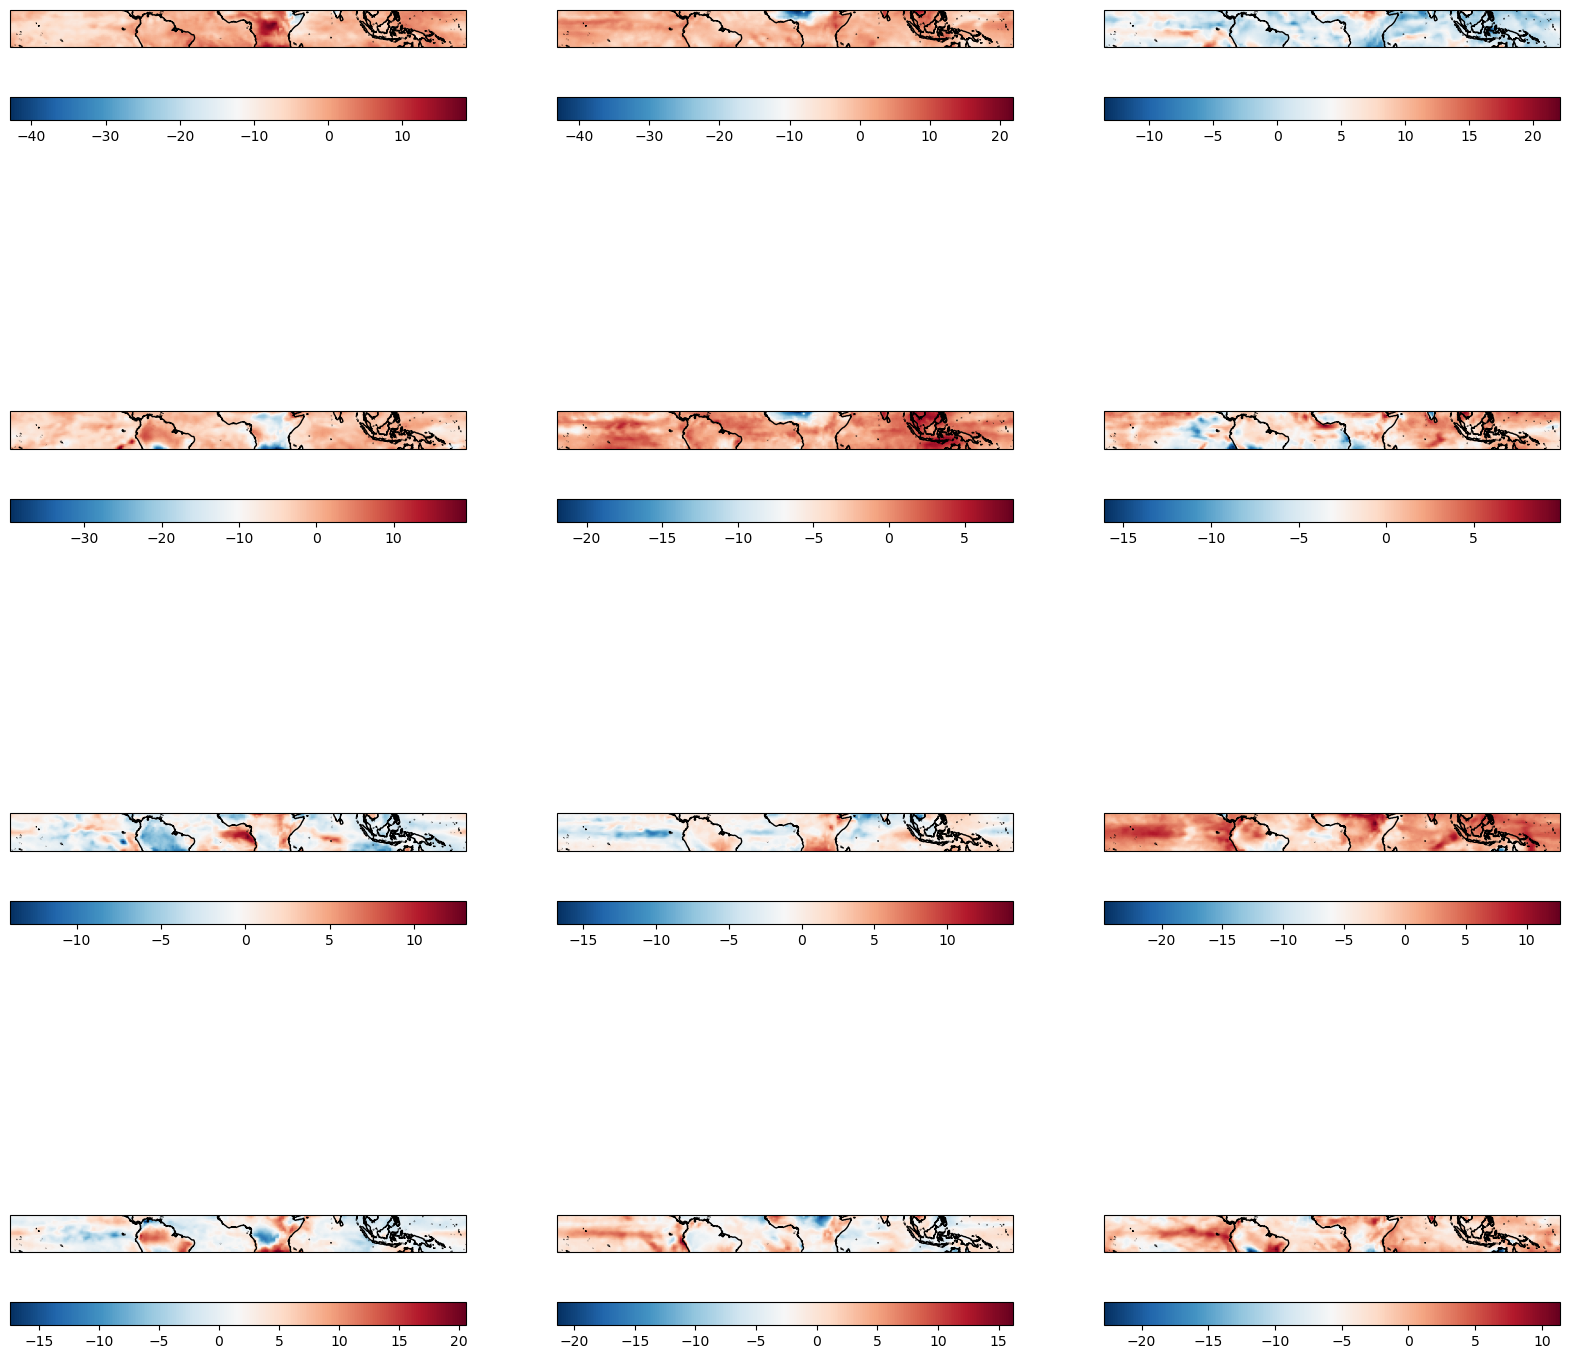

In [12]:
if VISUALIZE: 
    plot_examples(ds, examples=examples)

In [13]:
days = 7 # previously 5
time_len = len(ds.time.values)
time_coords = ds.time.values[:-days + 1]
if aggregate_func == 'mean':
    ds = ds.rolling(time=days).mean('time')
    ds = ds[{'time':slice((days-1),time_len)}].assign_coords(time=time_coords)
elif aggregate_func == 'sum':
    ds = ds.rolling(time=days).sum('time')
    ds = ds[{'time':slice((days-1),time_len)}].assign_coords(time=time_coords)

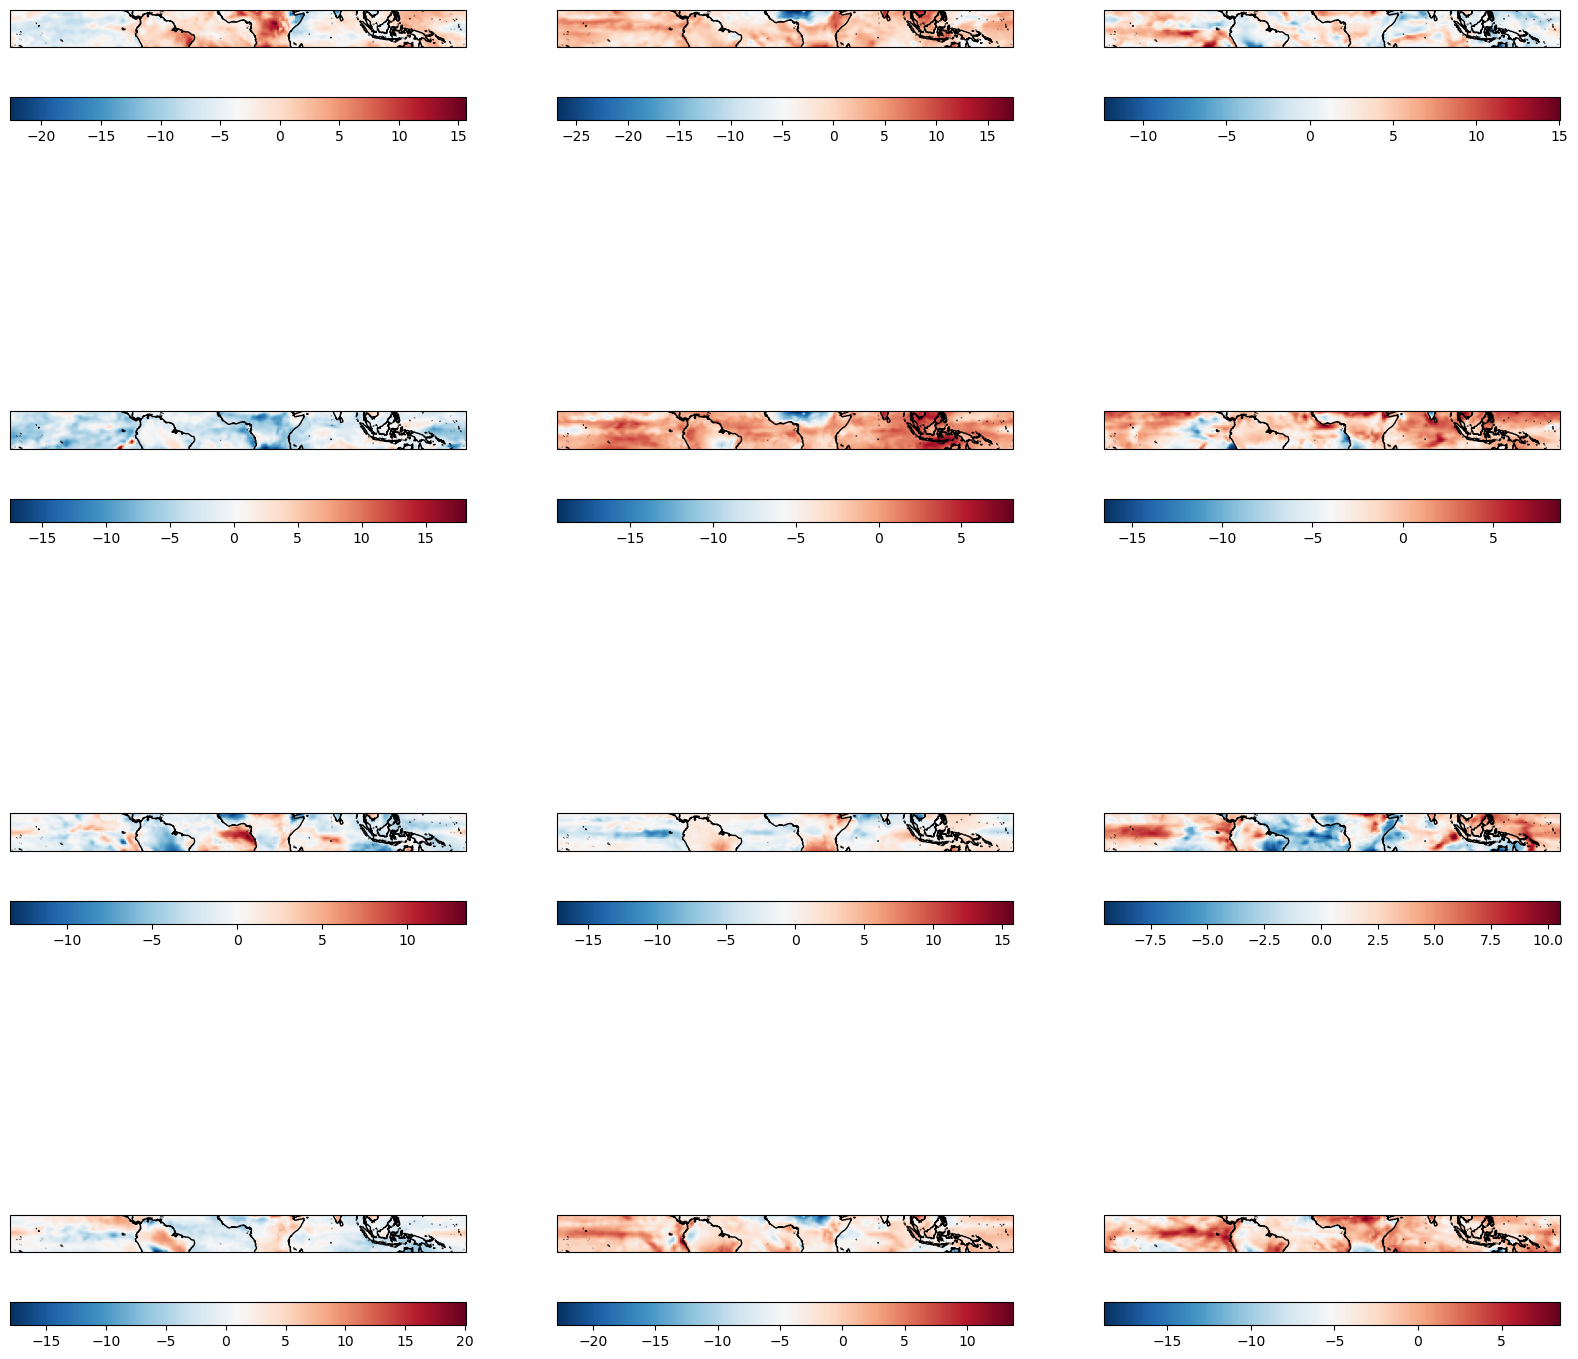

In [14]:
if VISUALIZE: 
    plot_examples(ds, examples=examples)

In [15]:
# compute seasons coordinates
yrs = np.arange(ds.isel(time=0).time.dt.year.values, ds.isel(time=-1).time.dt.year.values+1)
seas = []
for i in range(len(yrs)-1):
    year = yrs[i]
    ds_sel = ds.sel({'time':slice(np.datetime64(f'{year}-{start_season}'),np.datetime64(f'{year+1}-{end_season}'))})
    len_time = len(ds_sel.time.values)
    if i > 0:
        dst = xr.concat((dst,ds_sel), dim ='time')
        seas.append(len_time)
    if i ==0:
        seas = [len_time,len_time]
        dst = ds_sel
        del ds_sel
seas.append(len_time)
ds = dst
del ds_sel, dst

last = ds.isel(time=-1)
first = ds.isel(time=0)
seasons = seas
# cut days from first and last season that are not in dataset
cut_beginning = int((first.time.values - np.datetime64(f'{start_year - 1}-{start_season}')).astype(int) / (1e9 * 60 * 60 * 24))
cut_end = -1*int((last.time.values - np.datetime64(f'{end_year + 1}-{end_season}')).astype(int) / (1e9 * 60 * 60 * 24)) -7
seasons[0] -= cut_beginning
seasons[-1] -= cut_end

# add season coordinates along time dimension
season_coords = np.concatenate([s * [i] for i, s in enumerate(seasons)])
ds = ds.assign_coords(season=('time', season_coords))

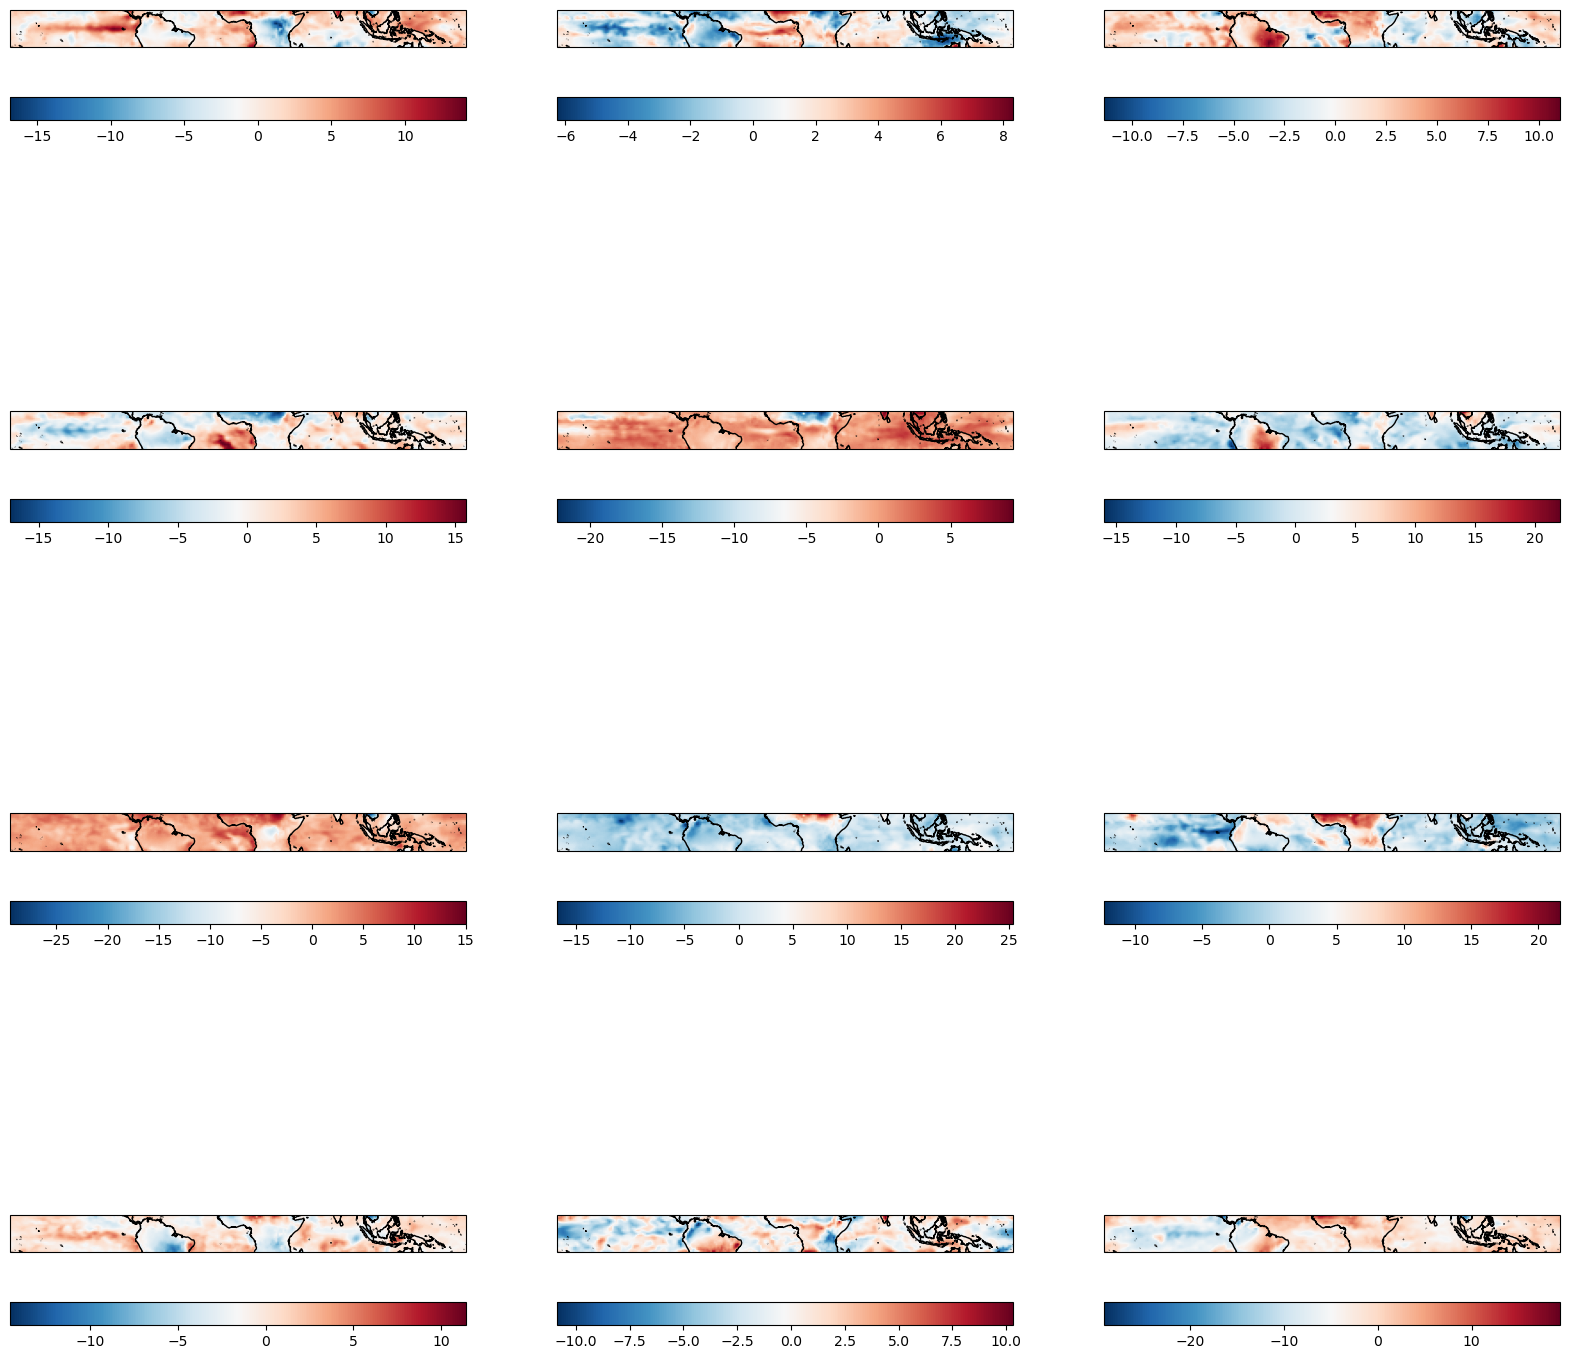

In [16]:
if VISUALIZE:
    examples = np.random.choice(np.arange(len(ds.time)), 12)
    plot_examples(ds, examples=examples)

In [ ]:
# Save.
dataset_dir = Path(f'{ddir}/{data_name}/datasets')
dataset_dir.mkdir(exist_ok=True)

file_name = dataset_dir / Path(f'{var_name}_{pressure_level}_{resolution}deg_{start_year}-{end_year}_{region}_{"1d" if reduce_to_single_dim else "2d"}.nc')

ds.to_netcdf(file_name, engine ="netcdf4")